<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Guassian-process-decision-model-fitting" data-toc-modified-id="Guassian-process-decision-model-fitting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Guassian process decision model fitting</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Load-grid-data" data-toc-modified-id="Load-grid-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load grid data</a></span></li><li><span><a href="#Simulate-data" data-toc-modified-id="Simulate-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Simulate data</a></span></li><li><span><a href="#Sampling" data-toc-modified-id="Sampling-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Sampling</a></span></li></ul></li></ul></div>

# Guassian process decision model fitting

This notebook provides an example of how to use the Gaussian process model fitting code.

A GPU is necessary for this to work, so make sure to use a Colab runtime with a GPU.

***Note: The script files from GitHub need to be uploaded to Colab before running.***

Check that we have a GPU

In [ ]:
!nvidia-smi

Tue Nov 23 16:00:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    57W / 149W |  10355MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install necessary dependencies (everything is pre-installed except NumPyro)

In [ ]:
!pip install numpyro

Imports

In [ ]:
from decision_strategies import *
from gp_model_functions import *
from model_fit import *
import jax
from jax.scipy.linalg import cholesky
import jax.numpy as jnp
import numpy as np
from jax import jit
import pandas as pd 

## Load data

This loads in subjects' data and puts it into arrays of the correct shape. Rewards are also transformed to range from -0.5 to +0.5 rather than 0 to 100.

We also calculate the squared distance between all points on the grid. This is useful as all the model-fitting functions require these distances, and we can speed up computation slightly by pre-computing them here.

In [ ]:
# Load data
data = pd.read_csv(r'https://firebasestorage.googleapis.com/v0/b/onlinetesting-96dd3.appspot.com/o/master.csv?alt=media&token=cccfe509-9542-44b5-a580-b18f07fabfb9')
data = data[data['krakenPres'] == 0]

# Get important numbers
N_SUBS = len(data['ID'].unique())
N_BLOCKS = len(data.loc[data['ID'] == 1, 'blocknr'].unique())
N_TRIALS = len(data['click'].unique())

# Initialise arrays
choices = np.zeros((N_SUBS, N_BLOCKS, N_TRIALS))
y = np.zeros((N_SUBS, N_BLOCKS, N_TRIALS))

GRID_SIZE = 11

# Extract and transform data
for n_sub, sub in enumerate(data['ID'].unique()):
    sub_df = data[data['ID'] == sub]
    for n_block, block in enumerate(sub_df['blocknr'].unique()):
        sub_block_df = sub_df[sub_df['blocknr'] == block]
        choices[n_sub, n_block, :] = np.ravel_multi_index(sub_block_df[['x', 'y']].values.T.astype(int), (GRID_SIZE, GRID_SIZE))
        y[n_sub, n_block, :] = (sub_block_df['z'] - 50) / 100
        
choices = choices.astype(int)

# Reshape data
choices_flat = np.reshape(choices, (N_SUBS * N_BLOCKS, N_TRIALS))
y_flat = np.reshape(y, (N_SUBS * N_BLOCKS, N_TRIALS))

# Deal with missing data
missing = np.isnan(y_flat)
y_flat[np.isnan(y_flat)] = 0

# One dimensional column vectors of inputs
x1 = np.arange(GRID_SIZE)[:, None]
x2 = np.arange(GRID_SIZE)[:, None]

# Make cartesian grid
X = jnp.dstack(np.meshgrid(x1.squeeze(), x2.squeeze())).reshape(-1, 2)

# Get distances
distances = jnp.sqrt(square_dist(X, 1))


## Load grid data

In order to simulate data for parameter recovery, we load example grids as a list of arrays.

In [ ]:
def make_grids(grids, size=12):
    out_grids = []
    
    for g in grids:
        new_grid = np.zeros((12, 12))
        for k, v in g.items():
            for n, i in v.items():
                new_grid[int(k), int(n)] = (i - 50) / 100
        out_grids.append(new_grid[:size, :size].copy())
        
    return out_grids

import requests
grids = requests.get(url=r'https://firebasestorage.googleapis.com/v0/b/onlinetesting-96dd3.appspot.com/o/sample_grid.json?alt=media&token=d6658b9b-b767-48ce-9d31-073812b256f5').json()
grid_arrays = make_grids(grids)

## Simulate data

First we generate simulated parameter values for 100 subjects.

These are sampled from uniform distributions with various upper and lower bounds. The bounds are important - values outside of these ranges can make model-fitting difficult as they generate slightly odd behaviour.

The $\beta$ parameter for the Upper Confidence Bound model is allowed to be positive or negative. Negative values are equivalent to the Lower Confidence Bound model with a positive $\beta$ parameter.

In [ ]:
rng_key = jax.random.PRNGKey(0)
N_SUBS_SIM = 100

missing = missing[:N_SUBS_SIM * N_BLOCKS, :]

ls_subject = jax.random.uniform(jax.random.PRNGKey(0), shape=(N_SUBS_SIM,), minval=0.3, maxval=5.3)
beta_subject = jax.random.uniform(jax.random.PRNGKey(1), shape=(N_SUBS_SIM,), minval=-.8, maxval=.8)
tau_subject = jax.random.uniform(jax.random.PRNGKey(2), shape=(N_SUBS_SIM,), minval=0.02, maxval=.22)

Then we simulate data using these parameter values.

In [ ]:
sim_choices_ucb, sim_x_coords_ucb, sim_y_ucb = simulate_data_UCB(ls_subject, 
                                                                 tau_subject, 
                                                                 beta_subject, 
                                                                 N_SUBS_SIM, 
                                                                 N_BLOCKS, 
                                                                 N_TRIALS, 
                                                                 grid_arrays[0], 
                                                                 distances)

# sim_choices_poi, sim_x_coords_poi, sim_y_poi = simulate_data_POI(ls_subject, 
#                                                                  tau_subject, 
#                                                                  N_SUBS_SIM, 
#                                                                  N_BLOCKS, 
#                                                                  N_TRIALS, 
#                                                                  grid_arrays[0], 
#                                                                  distances)

# sim_choices_pos, sim_x_coords_pos, sim_y_pos = simulate_data_POS(ls_subject, 
#                                                                  tau_subject, 
#                                                                  N_SUBS_SIM, 
#                                                                  N_BLOCKS, 
#                                                                  N_TRIALS, 
#                                                                  grid_arrays[0], 
#                                                                  distances)

## Sampling

We can then fit the model to this simulated data. To speed things up a bit, we only run 1 chain

In [ ]:
model_output = sample(grid_model_UCB, sim_x_coords_ucb, sim_choices_ucb, sim_y_ucb, missing, distances, N_SUBS_SIM, N_BLOCKS, N_TRIALS, n_samples=2000, n_warmup=1000)
posterior_samples = model_output.get_samples()

sample: 100%|██████████| 3000/3000 [35:47<00:00,  1.40it/s, 31 steps of size 1.53e-01. acc. prob=0.85]


And then plot the estimated parameter values against those used to generate the data.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


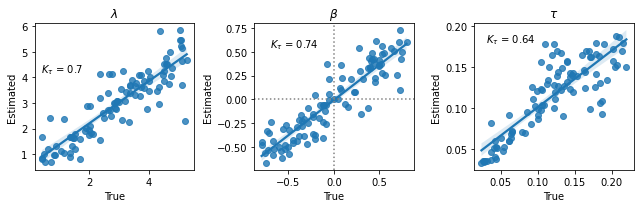

In [ ]:
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(1, 3, figsize=(9, 3))

sns.regplot(ls_subject, posterior_samples['ls_subject_transformed'].mean(axis=0), ax=ax[0])
ax[0].set_title(r'$\lambda$')

t, p = kendalltau(ls_subject, posterior_samples['ls_subject_transformed'].mean(axis=0))
ax[0].text(0.4, 4.2, r'$K_{\tau}$' + ' = {0}'.format(np.round(t, 2)))

sns.regplot(beta_subject, posterior_samples['beta_subject_transformed'].mean(axis=0), ax=ax[1])
ax[1].set_title(r'$\beta$')

t, p = kendalltau(beta_subject, posterior_samples['beta_subject_transformed'].mean(axis=0))
ax[1].text(-0.7, 0.55, r'$K_{\tau}$' + ' = {0}'.format(np.round(t, 2)))
ax[1].axvline(0, color='gray', linestyle=':')
ax[1].axhline(0, color='gray', linestyle=':')

sns.regplot(tau_subject, posterior_samples['tau_subject_transformed'].mean(axis=0), ax=ax[2])
ax[2].set_title(r'$\tau$')

t, p = kendalltau(tau_subject, posterior_samples['tau_subject_transformed'].mean(axis=0))
ax[2].text(0.03, 0.18, r'$K_{\tau}$' + ' = {0}'.format(np.round(t, 2)))

for i in range(3):
    ax[i].set_ylabel('Estimated')
    ax[i].set_xlabel('True')
    
plt.tight_layout()